## Preprocessing

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

def preprocess_dataset(df):
    # Create a copy of the dataframe
    df_processed = df.copy()
    
    # 1. Handle Time column - Convert Unix timestamp to datetime
    df_processed['Time'] = pd.to_datetime(df_processed['Time'], unit='s')
    
    # 2. Clean text data
    df_processed['Text'] = df_processed['Text'].str.strip()
    df_processed['Text'] = df_processed['Text'].fillna('')  # Handle any NaN values
    
    # 3. Clean and standardize category columns
    category_columns = ['Cat1', 'Cat2', 'Cat3']
    for col in category_columns:
        # Convert to lowercase and replace spaces with underscores
        df_processed[col] = df_processed[col].str.lower()
        df_processed[col] = df_processed[col].str.replace(' ', '_')
        
    # 4. Label encode categorical columns if needed
    le = LabelEncoder()
    df_processed['Cat1_encoded'] = le.fit_transform(df_processed['Cat1'])
    df_processed['Cat2_encoded'] = le.fit_transform(df_processed['Cat2'])
    df_processed['Cat3_encoded'] = le.fit_transform(df_processed['Cat3'])
    
    # 5. Create features from Title
    df_processed['title_length'] = df_processed['Title'].str.len()
    
    # 6. Create features from Text
    df_processed['text_length'] = df_processed['Text'].str.len()
    df_processed['word_count'] = df_processed['Text'].str.split().str.len()
    
    # 7. Extract time-based features
    df_processed['hour'] = df_processed['Time'].dt.hour
    df_processed['day_of_week'] = df_processed['Time'].dt.dayofweek
    df_processed['month'] = df_processed['Time'].dt.month
    
    return le, df_processed

df = pd.read_csv('/Users/nbhagat/hierarchy classification/transformed_dataset.csv')
le, processed_df = preprocess_dataset(df)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from typing import Dict, Tuple, List

class TextFeatureExtractor(BaseEstimator, TransformerMixin):
    """Custom transformer for text feature extraction"""
    def __init__(self, field, max_features=1000):
        self.field = field
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2)
        )
        
    def fit(self, X, y=None):
        # Fill NaN values with empty string
        text_data = X[self.field].fillna('')
        self.vectorizer.fit(text_data)
        return self
        
    def transform(self, X):
        # Fill NaN values with empty string
        text_data = X[self.field].fillna('')
        return self.vectorizer.transform(text_data)

class EnhancedHierarchicalClassifier:
    def __init__(
        self,
        text_max_features=1000,
        title_max_features=500,
        confidence_threshold=0.3,
        use_features_weights=True,
        use_class_weights=True
    ):
        self.text_max_features = text_max_features
        self.title_max_features = title_max_features
        self.confidence_threshold = confidence_threshold
        self.use_features_weights = use_features_weights
        self.use_class_weights = use_class_weights
        
        # Initialize feature extractors
        self.feature_extractors = [
            ('text', TextFeatureExtractor(
                field='Text',
                max_features=self.text_max_features
            )),
            ('title', TextFeatureExtractor(
                field='Title',
                max_features=self.title_max_features
            ))
        ]
        
        self.feature_extractor = FeatureUnion(self.feature_extractors)
        
        # Initialize classifiers and encoders
        self.classifiers = {
            'level1': None,
            'level2': {},
            'level3': {}
        }
        self.label_encoders = {
            'level1': LabelEncoder(),
            'level2': LabelEncoder(),
            'level3': LabelEncoder()
        }

    def preprocess_data(self, df):
        """Preprocess the input data"""
        df = df.copy()
        
        # Fill NaN values
        df['Text'] = df['Text'].fillna('')
        df['Title'] = df['Title'].fillna('')
        
        # Basic text cleaning
        df['Text'] = df['Text'].str.lower().str.strip()
        df['Title'] = df['Title'].str.lower().str.strip()
        
        # Remove special characters (optional)
        df['Text'] = df['Text'].str.replace(r'[^\w\s]', ' ', regex=True)
        df['Title'] = df['Title'].str.replace(r'[^\w\s]', ' ', regex=True)
        
        return df
    
    def _create_classifier(self, level: str, cat1: str = None, cat2: str = None):
        """Create a classifier with appropriate parameters"""
        return RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced' if self.use_class_weights else None,
            n_jobs=-1,
            random_state=42
        )
    
    def fit(self, df: pd.DataFrame, verbose: bool = True):
        """Fit the hierarchical classifier"""
        if verbose:
            print("Preprocessing data...")
        
        # Preprocess data
        df = self.preprocess_data(df)
        
        if verbose:
            print("Extracting features...")
        
        # Extract features
        X = self.feature_extractor.fit_transform(df)
        
        # Encode labels
        y1_encoded = self.label_encoders['level1'].fit_transform(df['Cat1'])
        y2_encoded = self.label_encoders['level2'].fit_transform(df['Cat2'])
        y3_encoded = self.label_encoders['level3'].fit_transform(df['Cat3'])
        
        # Train level 1
        if verbose:
            print("Training Level 1 classifier...")
        
        self.classifiers['level1'] = self._create_classifier('level1')
        self.classifiers['level1'].fit(X, y1_encoded)
        
        # Train level 2 classifiers
        if verbose:
            print("Training Level 2 classifiers...")
        
        for cat1 in df['Cat1'].unique():
            mask = df['Cat1'] == cat1
            if sum(mask) > 0:
                clf = self._create_classifier('level2', cat1)
                clf.fit(X[mask], y2_encoded[mask])
                self.classifiers['level2'][cat1] = clf
        
        # Train level 3 classifiers
        if verbose:
            print("Training Level 3 classifiers...")
        
        for cat1 in df['Cat1'].unique():
            for cat2 in df[df['Cat1'] == cat1]['Cat2'].unique():
                mask = (df['Cat1'] == cat1) & (df['Cat2'] == cat2)
                if sum(mask) > 0:
                    clf = self._create_classifier('level3', cat1, cat2)
                    clf.fit(X[mask], y3_encoded[mask])
                    self.classifiers['level3'][(cat1, cat2)] = clf
    
    def predict(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Predict classes for all levels"""
        # Preprocess data
        df = self.preprocess_data(df)
        
        # Extract features
        X = self.feature_extractor.transform(df)
        
        # Level 1 prediction
        y1_proba = self.classifiers['level1'].predict_proba(X)
        y1_pred = np.where(
            y1_proba.max(axis=1) >= self.confidence_threshold,
            self.label_encoders['level1'].inverse_transform(y1_proba.argmax(axis=1)),
            'unknown'
        )
        
        # Level 2 prediction
        y2_pred = np.array(['unknown'] * len(df))
        for cat1 in self.classifiers['level2']:
            mask = y1_pred == cat1
            if sum(mask) > 0:
                proba = self.classifiers['level2'][cat1].predict_proba(X[mask])
                pred = self.label_encoders['level2'].inverse_transform(proba.argmax(axis=1))
                y2_pred[mask] = np.where(
                    proba.max(axis=1) >= self.confidence_threshold,
                    pred,
                    'unknown'
                )
        
        # Level 3 prediction
        y3_pred = np.array(['unknown'] * len(df))
        for (cat1, cat2) in self.classifiers['level3']:
            mask = (y1_pred == cat1) & (y2_pred == cat2)
            if sum(mask) > 0:
                proba = self.classifiers['level3'][(cat1, cat2)].predict_proba(X[mask])
                pred = self.label_encoders['level3'].inverse_transform(proba.argmax(axis=1))
                y3_pred[mask] = np.where(
                    proba.max(axis=1) >= self.confidence_threshold,
                    pred,
                    'unknown'
                )
        
        return y1_pred, y2_pred, y3_pred

def evaluate_model(df_train: pd.DataFrame, df_test: pd.DataFrame):
    """Train and evaluate model"""
    # Check for missing values
    print("\nMissing values in training data:")
    print(df_train.isnull().sum())
    
    print("\nMissing values in test data:")
    print(df_test.isnull().sum())
    
    # Initialize model
    model = EnhancedHierarchicalClassifier(
        text_max_features=1000,
        title_max_features=500,
        confidence_threshold=0.3
    )
    
    print("\nTraining model...")
    model.fit(df_train)
    
    print("\nMaking predictions...")
    y1_pred, y2_pred, y3_pred = model.predict(df_test)
    
    # Evaluate
    print("\nEvaluation Results:")
    for level, (pred, true) in enumerate([
        (y1_pred, df_test['Cat1']),
        (y2_pred, df_test['Cat2']),
        (y3_pred, df_test['Cat3'])
    ], 1):
        print(f"\nLevel {level} Performance:")
        print(classification_report(true, pred))

# Example usage
if __name__ == "__main__":
    # Load data
    df = transformed_df
    
    # Print initial data info
    print("Dataset Info:")
    print(df.info())
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Split data
    from sklearn.model_selection import train_test_split
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    
    # Train and evaluate
    evaluate_model(df_train, df_test)


In [66]:
df = pd.read_csv('/Users/nbhagat/hierarchy classification/transformed_dataset.csv')

In [13]:
feature_extractors = [
            ('text', TextFeatureExtractor(
                field='Text',
                max_features=1000
            )),
            ('title', TextFeatureExtractor(
                field='Title',
                max_features=1000
            ))
        ]
        
feature_extractor = FeatureUnion(feature_extractors)
        

In [ ]:
df['count'] = df.groupby(['Cat1', 'Cat2', 'Cat3']).transform('size')
df_rare = df[df['count'] < 10]
df = df[df['count'] >= 10]
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [70]:
df_train = pd.concat([df_train, df_rare], ignore_index=True)

In [71]:
X = df_train[['Title', 'Text', 'Cat1', 'Cat2']]
y = df_train['Cat3']

X = feature_extractor.fit_transform(X)

In [72]:
endoder = LabelEncoder()
y = endoder.fit_transform(y)

In [73]:
rf = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        )

In [74]:
rf.fit(X,y)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [75]:
X = df_test[['Title', 'Text', 'Cat1', 'Cat2']]
y = df_test['Cat3']

X = feature_extractor.transform(X)
y_ = endoder.transform(y)

In [ ]:
y_pred = rf.predict(X)

In [81]:
from pycm import *
cm = ConfusionMatrix(actual_vector=list(y_), predict_vector=list(y_pred))

In [94]:
max(cm.class_stat['F1'])

np.int64(232)

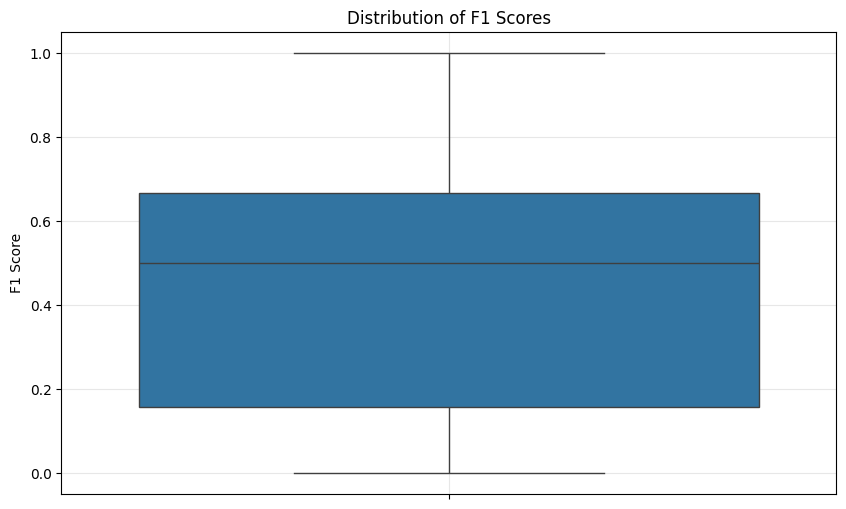

In [95]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=cm.class_stat['F1'])
plt.title('Distribution of F1 Scores')
plt.ylabel('F1 Score')
plt.grid(True, alpha=0.3)
plt.show()


Type of cm.class_stat['F1']: <class 'dict'>
Content of F1 scores: {np.int64(0): 0.0, np.int64(1): 0.7692307692307693, np.int64(2): 0.0, np.int64(3): 0.0, np.int64(4): 0.5714285714285714, np.int64(5): 0.782608695652174, np.int64(6): 0.6, np.int64(7): 0.5714285714285714, np.int64(8): 0.5714285714285714, np.int64(9): 0.16666666666666666, np.int64(10): 0.0, np.int64(11): 0.25, np.int64(12): 0.0, np.int64(13): 0.3333333333333333, np.int64(14): 0.5714285714285714, np.int64(15): 0.2857142857142857, np.int64(17): 0.5625, np.int64(18): 0.0, np.int64(19): 0.6, np.int64(20): 0.0, np.int64(21): 0.2, np.int64(22): 0.0, np.int64(23): 0.4, np.int64(24): 0.6153846153846154, np.int64(25): 0.0, np.int64(27): 0.5, np.int64(29): 1.0, np.int64(30): 0.0, np.int64(31): 0.0, np.int64(32): 0.5, np.int64(34): 0.2857142857142857, np.int64(35): 0.2, np.int64(36): 0.4, np.int64(37): 0.8, np.int64(39): 0.35294117647058826, np.int64(40): 0.14285714285714285, np.int64(41): 0.0, np.int64(42): 0.5, np.int64(43): 0.2424

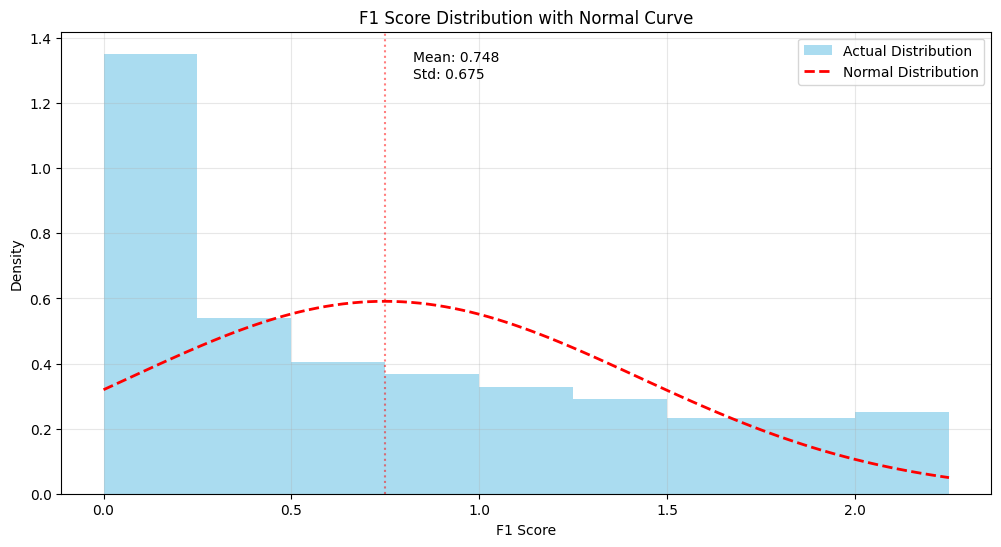

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# First, let's check what we're working with
print("Type of cm.class_stat['F1']:", type(cm.class_stat['F1']))
print("Content of F1 scores:", cm.class_stat['F1'])

# Convert the values to a list if they aren't already
f1_scores = f1_weighted # If it's another iterable

# Convert to numpy array
f1_scores = np.array(f1_scores)

# Now create the plot
plt.figure(figsize=(12, 6))

# Plot histogram of actual data
plt.hist(f1_scores, bins='auto', density=True, alpha=0.7, color='skyblue', label='Actual Distribution')

# Create bell curve
mu = np.mean(f1_scores)
sigma = np.std(f1_scores)
x = np.linspace(min(f1_scores), max(f1_scores), 100)
bell_curve = stats.norm.pdf(x, mu, sigma)

# Plot the bell curve
plt.plot(x, bell_curve, 'r--', label='Normal Distribution', linewidth=2)

# Add labels and title
plt.title('F1 Score Distribution with Normal Curve', fontsize=12)
plt.xlabel('F1 Score', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()

# Add mean line and annotations
plt.axvline(mu, color='red', linestyle=':', alpha=0.5)
plt.text(mu*1.1, plt.ylim()[1]*0.9, f'Mean: {mu:.3f}\nStd: {sigma:.3f}')

# Print some statistics
print(f"\nStatistics:")
print(f"Mean F1 Score: {mu:.3f}")
print(f"Standard Deviation: {sigma:.3f}")
print(f"Min F1 Score: {min(f1_scores):.3f}")
print(f"Max F1 Score: {max(f1_scores):.3f}")

plt.show()


In [150]:
def calculate_weighted_f1(cm):
    """_summary_
    Function to calculated weight F1 score
    Args:
        cm (_type_): pycm confusion matrix

    Returns:
        _type_: weighted F1 score
    """
    weights = [i/sum(cm.class_stat['P'].values()) for i in list(cm.class_stat['P'].values())]
    f1_weighted = []
    for i in range(len(list((cm.class_stat['P'])))):
        f1_weighted.append(weights[i]*list(cm.class_stat['F1'].values())[i])
    return f1_weighted, sum(f1_weighted)/len(f1_weighted)

In [151]:
f1, score = calculate_weighted_f1(cm)
score

0.0026372510863453278


Weighted Statistics:
Weighted Mean F1 Score: 0.447
Weighted Standard Deviation: 0.324
Min F1 Score: 0.000
Max F1 Score: 1.000
Total Probability Sum: 1.000

Detailed Class Statistics:
F1 Score | Probability
---------+------------
  0.000 |      0.000
  0.769 |      0.000
  0.000 |      0.000
  0.000 |      0.000
  0.571 |      0.000
  0.783 |      0.000
  0.600 |      0.000
  0.571 |      0.000
  0.571 |      0.000
  0.167 |      0.000
  0.000 |      0.000
  0.250 |      0.000
  0.000 |      0.001
  0.333 |      0.001
  0.571 |      0.001
  0.286 |      0.001
  0.562 |      0.001
  0.000 |      0.001
  0.600 |      0.001
  0.000 |      0.001
  0.200 |      0.001
  0.000 |      0.001
  0.400 |      0.001
  0.615 |      0.001
  0.000 |      0.001
  0.500 |      0.001
  1.000 |      0.001
  0.000 |      0.001
  0.000 |      0.001
  0.500 |      0.001
  0.286 |      0.001
  0.200 |      0.001
  0.400 |      0.002
  0.800 |      0.002
  0.353 |      0.002
  0.143 |      0.002
  0.000 |     

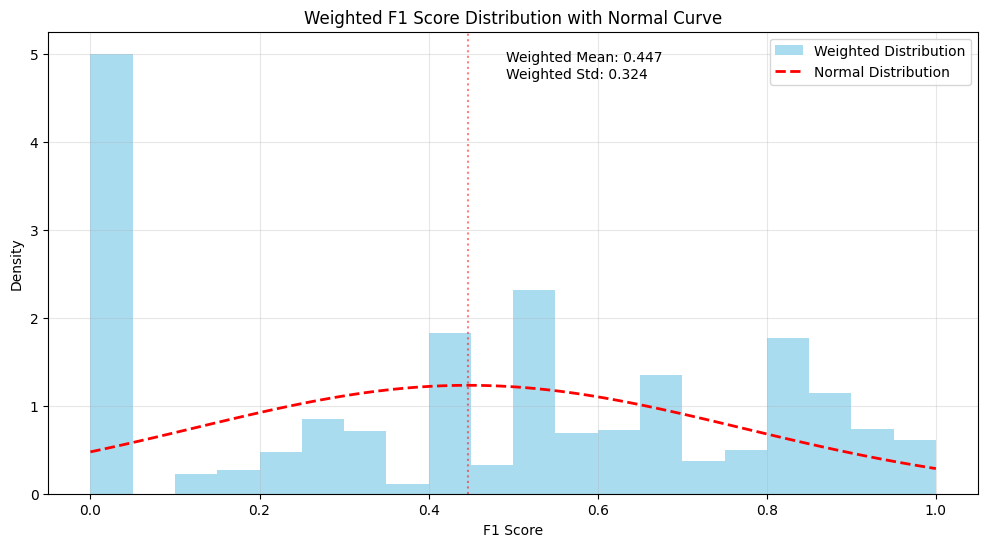

In [144]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Get F1 scores and probabilities
f1_scores = np.array(list(cm.class_stat['F1'].values()))
probabilities = np.array(weights)

plt.figure(figsize=(12, 6))

# Plot weighted histogram with explicit number of bins
n_bins = 20  # you can adjust this number
plt.hist(f1_scores, bins=n_bins, weights=probabilities, density=True, 
         alpha=0.7, color='skyblue', label='Weighted Distribution')

# Create weighted statistics
weighted_mean = np.average(f1_scores, weights=probabilities)
weighted_std = np.sqrt(np.average((f1_scores - weighted_mean)**2, weights=probabilities))

# Create bell curve with weighted parameters
x = np.linspace(min(f1_scores), max(f1_scores), 100)
bell_curve = stats.norm.pdf(x, weighted_mean, weighted_std)

# Plot the bell curve
plt.plot(x, bell_curve, 'r--', label='Normal Distribution', linewidth=2)

# Add labels and title
plt.title('Weighted F1 Score Distribution with Normal Curve', fontsize=12)
plt.xlabel('F1 Score', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()

# Add mean line and annotations
plt.axvline(weighted_mean, color='red', linestyle=':', alpha=0.5)
plt.text(weighted_mean*1.1, plt.ylim()[1]*0.9, 
         f'Weighted Mean: {weighted_mean:.3f}\nWeighted Std: {weighted_std:.3f}')

# Print statistics
print("\nWeighted Statistics:")
print(f"Weighted Mean F1 Score: {weighted_mean:.3f}")
print(f"Weighted Standard Deviation: {weighted_std:.3f}")
print(f"Min F1 Score: {min(f1_scores):.3f}")
print(f"Max F1 Score: {max(f1_scores):.3f}")
print(f"Total Probability Sum: {sum(probabilities):.3f}")

# Print detailed class statistics
print("\nDetailed Class Statistics:")
print("F1 Score | Probability")
print("---------+------------")
for f1, p in zip(f1_scores, probabilities):
    print(f"{f1:7.3f} | {p:10.3f}")

plt.show()


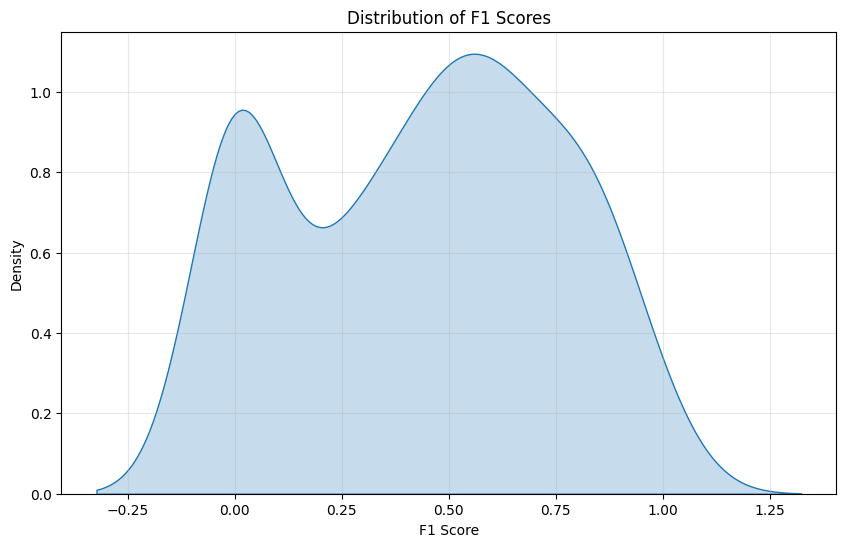

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.kdeplot(data=cm.class_stat['F1'], fill=True)
plt.title('Distribution of F1 Scores')
plt.xlabel('F1 Score')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.show()


In [90]:
cm.class_stat['P']

{np.int64(0): 4,
 np.int64(1): 7,
 np.int64(2): 3,
 np.int64(3): 0,
 np.int64(4): 5,
 np.int64(5): 11,
 np.int64(6): 11,
 np.int64(7): 4,
 np.int64(8): 5,
 np.int64(9): 11,
 np.int64(10): 9,
 np.int64(11): 4,
 np.int64(12): 6,
 np.int64(13): 4,
 np.int64(14): 4,
 np.int64(15): 3,
 np.int64(17): 16,
 np.int64(18): 6,
 np.int64(19): 4,
 np.int64(20): 3,
 np.int64(21): 7,
 np.int64(22): 0,
 np.int64(23): 5,
 np.int64(24): 6,
 np.int64(25): 2,
 np.int64(27): 6,
 np.int64(29): 2,
 np.int64(30): 2,
 np.int64(31): 2,
 np.int64(32): 13,
 np.int64(34): 6,
 np.int64(35): 5,
 np.int64(36): 4,
 np.int64(37): 3,
 np.int64(39): 8,
 np.int64(40): 6,
 np.int64(41): 9,
 np.int64(42): 3,
 np.int64(43): 15,
 np.int64(44): 13,
 np.int64(45): 1,
 np.int64(46): 11,
 np.int64(47): 4,
 np.int64(49): 3,
 np.int64(50): 2,
 np.int64(51): 11,
 np.int64(52): 6,
 np.int64(53): 14,
 np.int64(54): 27,
 np.int64(55): 7,
 np.int64(56): 6,
 np.int64(58): 3,
 np.int64(59): 3,
 np.int64(60): 2,
 np.int64(61): 5,
 np.int64

In [83]:
pos = 0
nev = 0
for idx in range(len(y_pred)):
    if y_pred[idx] == y_[idx]:
        pos+=1
    else:
        nev+=1

In [84]:
pos

1125

In [85]:
nev

860